# COVID Simulation Walkthrough

This file demonstrates how the Monte Carlo simulations are constructed for assessing the re-identification risk of different policies when sharing pandemic data, using COVID-19 as an example:

In [1]:
"""
Simulation walkthrough
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data
First, we will upload the COVID-19 daily case counts data from the Johns Hopkins University (JHU) COVID-19 surveillance data repository:

In [6]:
# import and format Johns Hopkins data

# pull data from url
url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
       'master/csse_covid_19_data/csse_covid_19_time_series/'
       'time_series_covid19_confirmed_US.csv')

data = pd.read_csv(url)

# filter out null FIPS codes
data = data[data.FIPS.notnull()].fillna(0)

# convert cumulative counts to daily counts
date_columns = [col for col in data if col.endswith('20')|col.endswith('21')]
df = pd.DataFrame()

for i in range(1, len(date_columns)):
    today = date_columns[i]
    yesterday = date_columns[i-1]
    df[today] = data.loc[:, today] - data.loc[:, yesterday]
    
# remove negative values
df[df < 0] = 0

df.index = data.FIPS.astype(int)

df.head()

,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,...,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,10,0,5,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,40,0,42,0,16,0,0,0
1005,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,6,0,0,0,0,0
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,8,0,12,0,1,0,0,0


Next, we will upload the PCT12 data that I transformed in the following format:

In [4]:
# import census data
census = pd.read_csv("PCT12_combined_all_multiindex.csv")

census.head(10)

,fips,race,age,sex,counts,ethnicity
0,5131,w,0,Male,52,hl
1,5131,w,1,Male,60,hl
2,5131,w,2,Male,65,hl
3,5131,w,3,Male,66,hl
4,5131,w,4,Male,66,hl
5,5131,w,5,Male,63,hl
6,5131,w,6,Male,58,hl
7,5131,w,7,Male,69,hl
8,5131,w,8,Male,60,hl
9,5131,w,9,Male,61,hl


# Code

The "generalize" helper function, defined below, generalizes and formats the census data. The final format is shown below this cell. The example policy 

In [5]:
def generalize(df, ind_col = "fips", ages = False, races = False, sexes = False, ethnicities = False):
    """
    Generalizes census data for age, race, sex, and/or ethnicity.
    """
    temp = df.copy()
    
    # generalize bin values
    if ages:
        temp['age'] = pd.cut(temp['age'],ages, right=False) 
    if races:
        for key, value in races.items():
            for val in value:
                temp.loc[temp.race == val, 'race'] = key         
    if sexes:
        temp['sex'] = 'both_sex'
    if ethnicities:
        temp['ethnicity'] = 'both_ethnicity'
        
    # groupby and sum values per demographic bin
    new_temp = temp.groupby([ind_col, 'sex', 'race', 'age', 'ethnicity'])\
                    .agg({'counts':'sum'})\
                    .astype({'counts':int})\
                    .reset_index()
    # label each bin
    new_temp['bins'] = new_temp['sex'] + \
                        ',' + new_temp['race'] + \
                        ',' + new_temp['ethnicity'] + \
                        ',' + new_temp['age']\
                        .astype(str)
    
    return new_temp.pivot_table(index = ind_col, columns = 'bins', values = 'counts')

# example
generalize(census,
           ages = [0, 15, 30, 45, 60, 75, 90, 120],
           races = {'other':['ai_an', 'nh_pi', 'other', 'mixed']}).head()

bins,"Female,a,hl,[0, 18)","Female,a,hl,[18, 30)","Female,a,hl,[30, 40)","Female,a,hl,[40, 50)","Female,a,hl,[50, 60)","Female,a,hl,[60, 70)","Female,a,hl,[70, 80)","Female,a,hl,[80, 90)","Female,a,hl,[90, 120)","Female,a,nh,[0, 18)",...,"Male,w,hl,[90, 120)","Male,w,nh,[0, 18)","Male,w,nh,[18, 30)","Male,w,nh,[30, 40)","Male,w,nh,[40, 50)","Male,w,nh,[50, 60)","Male,w,nh,[60, 70)","Male,w,nh,[70, 80)","Male,w,nh,[80, 90)","Male,w,nh,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
1001,1,1,0,1,0,0,0,0,0,61,...,0,5416,2881,2779,3363,2733,1941,1176,358,41
1003,32,24,23,13,5,0,0,0,0,162,...,4,16458,9107,8915,10610,10747,9677,5916,2470,292
1005,0,0,0,0,0,0,0,0,0,8,...,0,1129,887,944,1110,1031,970,531,204,20
1007,0,0,0,0,0,0,0,0,0,3,...,0,2083,1232,1277,1373,1197,953,501,161,13
1009,10,5,10,6,2,1,0,0,0,4,...,4,5975,3344,3169,3759,3517,2912,1671,550,67


Finally, we have the MC_sim_dep_lag class. This class is used to run a Monte Carlo simulation, where sampling is performed without replacement (dependent sampling) and the pk risk metrics are measured on a lagging period of a user-specified size. I will walk through the details of this class.

In [5]:
class Privacy_risk_estimation_PK:
    """
    Uses Monte Carlo sampling techniques (without replacement) to estimate the longitudinal PK risk
    for a user-specified k value. The PK risk is estimated for each time point in a given county,
    when sharing data under a specific data sharing policy (which defines the demographic bins). 
    The PK risk values are calculated on a lagged period of "infected" individuals.
    
    Input:
    counts = Dataframe of the case counts per day (e.g. modified JHU case counts data from above).
             Must include the fips code in the index and the columns must be date values.
    gen_census = The generalized census, i.e., the output of the generalize function above for the
                 specified fips code.
    fips = The fips code of interest. Must be of the same format of the counts dataframe index column.
    n_sims = The number of simulations to be run in the experiment.
    k = The k value to be used in the PK risk calculation. Default is 10.
    period_size = The size of the lagging period to be used for calculating the PK risk values.
                  Default value is 3.
    
    Output:
    self.PK = Dataframe where each row is a unique simulation and each column is a day. Each cell
              value corresponds to the proportion of infected individuals who fall into a demographic
              bin of size k or less. The self.PK values are calculated from a lagged period of
              individuals, whose size is specified by period_size. For example, if period_size = 3 and
              the dataset is updated daily, the PK risk value on a given day in a given simulation is 
              the proportion of infected individuals from the day and the previous two days who fall into a 
              demographic bin of size k or less.
    """
    def __init__(self, counts, gen_census, fips, n_sims, k=10, period_size=3, rng=np.random.default_rng()):
        self.counts = counts.loc[fips,:].values
        self.dates = counts.columns
        self.census = gen_census
        self.n_bins = len(self.census)
        self.PK = pd.DataFrame(columns = self.dates)
        self.n_sims = n_sims
        self.xk = np.arange(self.n_sims)
        self.k = k
        self.period_size = period_size
        self.frames = []
        self.rng = rng
        self.infected_period = np.zeros((self.n_sims, self.n_bins))
        
    def create_original_bins_array(self):
        self.full_pop = np.tile(self.census.values, (self.n_sims,1))
        self.non_empty = sum(self.full_pop[0] > 0)
        
    def create_original_sampling_array(self):
        ppl = self.full_pop[0]
        self.row = np.concatenate(list(map(lambda i: np.repeat(i, ppl[i]), range(len(ppl)))),axis=0)
        # true shuffle if more than one equivalence class
        if len(self.full_pop[0]) > 1:
            self.shuffle_Uninfected()
        else:
            self.shuffle_Uninfected(False)
        
    def shuffle_Uninfected(self, true_shuffle=True):
        total_ppl = self.counts.sum()
        if true_shuffle:
            self.Uninfected = np.stack(list(map(lambda sim: self.rng.choice(self.row, size=total_ppl, replace=False),
                                         range(self.n_sims))), axis=0)
        else:
            row = self.row[:total_ppl]
            self.Uninfected = np.tile(row, (self.n_sims, 1))
        #del self.row
        
    def run_full_sim(self):
        self.create_original_bins_array()
        self.create_original_sampling_array()
        
        fill_zeros = True
        
        for i in range(len(self.dates)):
            date = self.dates[i]
            self.n_ppl = self.counts[i]
            
            if fill_zeros:
                if (self.n_ppl == 0):
                    self.marketer[date] = [0] * self.n_sims
                    self.PK1[date] = [0] * self.n_sims
                    self.PK3[date] = [0] * self.n_sims
                    self.PK5[date] = [0] * self.n_sims
                    self.PK10[date] = [0] * self.n_sims
                else:
                    self.single_day()
                    self.update_frames()
                    self.marketer[date] = self.calc_marketer_risk()
                    self.PK1[date] = self.calc_PK_risk()
                    self.PK3[date] = self.calc_PK_risk(3)
                    self.PK5[date] = self.calc_PK_risk(5)
                    self.PK10[date] = self.calc_PK_risk(10)
                    fill_zeros = False
                
            else:
                self.single_day()
                self.update_frames()
                self.marketer[date] = self.calc_marketer_risk()
                self.PK1[date] = self.calc_PK_risk()
                self.PK3[date] = self.calc_PK_risk(3)
                self.PK5[date] = self.calc_PK_risk(5)
                self.PK10[date] = self.calc_PK_risk(10)
                
    def single_day(self):
        # empty array for the day's infected per bin per simulation
        self.infected_day = np.zeros((self.n_sims, self.n_bins))
        # split shuffled values on sample size
        samples, self.Uninfected = np.split(self.Uninfected, [self.n_ppl], axis=1)
        # add infected people per bin
        for i in samples.T:
            self.infected_day[self.xk,i] += 1
        # update infected counts
        self.infected_all += self.infected_day
            
    def calc_marketer_risk(self):
        with np.errstate(divide='ignore', invalid='ignore'):
            group_ratios = np.nan_to_num(self.infected_all / self.full_pop)
        return group_ratios.sum(axis=1)/self.infected_all.sum(axis = 1)
    
    def drop_frame(self):
        self.frames.pop(0)
        
    def add_frame(self):
        self.frames.append(self.infected_day)
        
    def update_period(self):
        self.infected_period = sum(self.frames)
    
    def update_frames(self):
        if len(self.frames) == self.period_size:
            self.drop_frame()
            self.add_frame()
        else:
            self.add_frame()
        self.update_period()
    
    def calc_PK_risk(self, threshold=1):
        n_ppl = self.infected_period.sum(axis=1)[0]
        if n_ppl == 0:
            return [0] * self.n_sims
        elif threshold == 1:
            return np.count_nonzero(self.infected_period == 1, axis=1)/n_ppl
        else:
            risk = np.ndarray((self.n_sims, threshold))
            for i in range(1,threshold+1):
                risk[:,(i-1)] = np.count_nonzero(self.infected_period == i, axis=1) * i
            return risk.sum(axis=1)/n_ppl
        
    def get_stats(self, df, percentiles):
        stats = np.percentile(df, percentiles, axis=0)
        results = pd.DataFrame()
        results['date'] = self.dates
        results['lower'] = stats[0, :]
        results['mean'] = np.mean(df, axis=0).values
        results['upper'] = stats[1, :]

        return results

# Simulating who gets sick

First, I will walk through how the Monte Carlo simulation selects who gets sick in a county. Using the generalize function, I generalize the data into four bins: female <50 years old, females >= 50 years old, males < 50 years old, and males >= 50 years old.

In [6]:
gc = generalize(census,
                ages = [0, 50, 120],
                races = {'all_race':['w', 'b', 'ai_an', 'a', 'nh_pi', 'other', 'mixed']},
                sexes = False,
                ethnicities = True)

gc.loc[[47037, 47039, 47041],:]

bins,"Female,all_race,both_ethnicity,[0, 50)","Female,all_race,both_ethnicity,[50, 120)","Male,all_race,both_ethnicity,[0, 50)","Male,all_race,both_ethnicity,[50, 120)"
fips,,,,
47037,226475,96666,225234,78306
47039,3290,2669,3501,2297
47041,5762,3691,6091,3179


For this example, we will run 5 simulations for Davidson County, TN (FIPS code 47037). We will also define a lagging window of 3 days. The generalized census data for the Davidson county is shown above. According to the census, Davidson county has 226,475 females younger than 50 years old; 96,666 females 50 years and older; 225,234 males less than 50 years old; and 78,306 males 50 years and older. 

After initializing the class object, the full_pop array is created. The full_pop array keeps the numbers of full population separated by demographic bin according to the policy for each simulation. In this case, the array is of size 5x4: 5 simulations and 4 demographic bins in the policy.

In [7]:
mc = MC_sim_dep_lag(counts = df.loc[47037,:].to_frame().transpose(),
                    gen_census = gc.loc[47037,:],
                    fips = 47037,
                    n_sims = 5,
                    window_size = 3,
                    rng = np.random.default_rng(0)) # seeded for reproducibility

# create full population for each simulation
mc.create_original_bins_array()
mc.full_pop

array([[226475,  96666, 225234,  78306],
       [226475,  96666, 225234,  78306],
       [226475,  96666, 225234,  78306],
       [226475,  96666, 225234,  78306],
       [226475,  96666, 225234,  78306]])

Next the class creates a sampling array of the healthy individuals, i.e. before they are selected to be sick in the simulation. Each individual is represented by the index value of their demographic bin - the 226,475 females younger than 50 are represented as the index 0, the 96,666 females 50 and older are represented as the index 1, etc.

In [8]:
# create healthy population
mc.create_original_sampling_array()
# show how many 0, 1, 2, and 3 index values are in each row.
print(pd.Series(mc.row).value_counts())

0    226475
2    225234
1     96666
3     78306
dtype: int64


Identical copies of each row are stacked in an array according to the number of simulations. In this case, we are running five simulations, so the healthy array will have five rows. To randomly sample who gets sick, we independently shuffle each row a single time. The healthy array is shown below:

In [9]:
print("Healthy array shape:", mc.healthy.shape)

mc.healthy

Healthy array shape: (5, 51143)


array([[0, 2, 2, ..., 1, 2, 2],
       [3, 0, 2, ..., 2, 3, 0],
       [0, 1, 2, ..., 2, 1, 2],
       [2, 1, 1, ..., 2, 2, 0],
       [2, 1, 0, ..., 0, 2, 2]])

Notice how each row of the healthy array does not have 626,681 individuals (226475 + 96666 + 225234 + 78306) represented. This is because I adjusted the class object to only keep the number of individuals needed in the simulation according to the input case counts. In this case, the Johns Hopkins data indicates that Davidson county had 50,353 cases up to the date this walkthrough was generated. Therefore, the healthy array is constrained to hold the first 50,353 individuals randomly selected from the full population of individuals.

Now that we have the shuffled population, we can simulate who gets sick. How many cases per day is normally defined by the Johns Hopkins data, but in this example we will say 1 case was reported on the first day. The simulation takes the first index value from each row of the healthy array and adds it to the same row of the sick_day array. The sick_day array is the same size as the full_pop array (5x4) and holds the counts of how many people are sick per demographic bin per simulation on the specific day.

In [10]:
# single day with 1 cases
mc.n_ppl = 1
mc.single_day()
mc.update_frames()

print('sick_day:')
print(mc.sick_day)

sick_day:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


The first individual from the top row (simulation) of the healthy array (above) to get sick has index value 2. That results in one individual in the 2-index bin in the first row of the sick_day array. The counts for each cell on the other rows are counted similarly.

When the healthy individuals are "infected", they are removed from the healthy array and added to the sick_day array. Notice how the number of columns in the healthy array has now reduced by 1:

In [11]:
print("New healthy array shape:", mc.healthy.shape)

New healthy array shape: (5, 51142)


In addition to the sick_day array, the class object holds the sick_window and sick_all arrays. These arrays are identical in format and purpose to the sick_day array, but they hold the counts for the lagging window (with a window size of 3 the sick_window will hold the counts from the current day and the previous 2 days in the simulation) and total cumulative cases. On day one, all three sick arrays should have the same counts.

In [12]:
print('sick_window:')
print(mc.sick_window)
print()
print('sick_all:')
print(mc.sick_all)

sick_window:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]

sick_all:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


We will continue the simulation on the next day with two cases. Notice how the sick_window and sick_all arrays now have the same count values in each cell, while the sick_day array only has the counts from the current day in the simulation.

In [13]:
# second day with 2 cases
print("Healthy, before 2 more cases:")
print(mc.healthy)
print()

mc.n_ppl = 2
mc.single_day()
mc.update_frames()

print("Healthy array shape after 2 more cases:", mc.healthy.shape)
print()
print('sick_day:')
print(mc.sick_day)
print()
print('sick_window:')
print(mc.sick_window)
print()
print('sick_all:')
print(mc.sick_all)

Healthy, before 2 more cases:
[[2 2 1 ... 1 2 2]
 [0 2 1 ... 2 3 0]
 [1 2 1 ... 2 1 2]
 [1 1 0 ... 2 2 0]
 [1 0 0 ... 0 2 2]]

Healthy array shape after 2 more cases: (5, 51140)

sick_day:
[[0. 0. 2. 0.]
 [1. 0. 1. 0.]
 [0. 1. 1. 0.]
 [0. 2. 0. 0.]
 [1. 1. 0. 0.]]

sick_window:
[[1. 0. 2. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [0. 2. 1. 0.]
 [1. 1. 1. 0.]]

sick_all:
[[1. 0. 2. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [0. 2. 1. 0.]
 [1. 1. 1. 0.]]


Now we will simulate 3 more days, with 3, 2, and 1 cases, respectively. Notice how the sick_day array only has one person in each row, the sick_window array has 6 people in each row (the counts from the most recent 3 days), and the sick_all array has 9 people represented in each row (as there have been 9 total case counts through this day in the simulation.

In [14]:
# 3 more days
mc.n_ppl = 3
mc.single_day()
mc.update_frames()
mc.n_ppl = 2
mc.single_day()
mc.update_frames()
mc.n_ppl = 1
mc.single_day()
mc.update_frames()

print("New healthy array shape:", mc.healthy.shape)
print()
print('sick_day:')
print(mc.sick_day)
print()
print('sick_window:')
print(mc.sick_window)
print()
print('sick_all:')
print(mc.sick_all)

New healthy array shape: (5, 51134)

sick_day:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]

sick_window:
[[2. 1. 2. 1.]
 [2. 1. 1. 2.]
 [1. 1. 2. 2.]
 [2. 0. 3. 1.]
 [1. 3. 1. 1.]]

sick_all:
[[3. 1. 4. 1.]
 [3. 1. 2. 3.]
 [2. 2. 3. 2.]
 [2. 2. 4. 1.]
 [2. 4. 2. 1.]]


# Marketer risk calculation

Now I will show how the marketer risk is calculated. The marketer risk is calculated on each day in the simulation using the sick_all array. This measures the marketer risk on the aggregated dataset under the assumption the attacker does not use date of diagnosis in their attack.

The calculation first involves summing the fractions of small f over big F in the marketer risk equation, for each row (simulation).

In [15]:
print('sick_all:')
print(mc.sick_all)
print()
print('full_pop:')
print(mc.full_pop)
print()
group_ratios = (mc.sick_all/mc.full_pop).sum(axis=1) # sum over rows
group_ratios

sick_all:
[[3. 1. 4. 1.]
 [3. 1. 2. 3.]
 [2. 2. 3. 2.]
 [2. 2. 4. 1.]
 [2. 4. 2. 1.]]

full_pop:
[[226475  96666 225234  78306]
 [226475  96666 225234  78306]
 [226475  96666 225234  78306]
 [226475  96666 225234  78306]
 [226475  96666 225234  78306]]



array([5.41211157e-05, 7.07822887e-05, 6.83811027e-05, 6.00505163e-05,
       7.18606601e-05])

The values are then averaged by the number of total cases. This array holds five values; the marketer risk for each simulation. The mean value of these five simulations would be the expected marketer risk, for the specific policy and specific county on this day.

In [16]:
group_ratios/mc.sick_all.sum(axis=1)

array([6.01345730e-06, 7.86469874e-06, 7.59790030e-06, 6.67227958e-06,
       7.98451779e-06])

# pk risk calculation

Finally, I will show how the pk risk is calculated when k=1. The pk risk is calculated on each day in the simulation using the sick_window array. This measures the proportion of sick individuals who fall into a demographic bin of size k or smaller, under the relaxed assumption that the attacker only knows the window in which the target was diagnosed.

In [17]:
print('sick_window:')
print(mc.sick_window)
print()
print('pk risk for each simulation:')
print(mc.calc_pk_risk(1))
print()
print('Expected risk =', np.mean(mc.calc_pk_risk(1)))

sick_window:
[[2. 1. 2. 1.]
 [2. 1. 1. 2.]
 [1. 1. 2. 2.]
 [2. 0. 3. 1.]
 [1. 3. 1. 1.]]

pk risk for each simulation:
[0.33333333 0.33333333 0.33333333 0.16666667 0.5       ]

Expected risk = 0.33333333333333337


None of the cases are alone in a demographic bin in the first simulation, 1/6 of the cases are unique in a demographic bin in the second simulation, etc. The expected pk risk value, for this county and policy and on this day, is about 0.13.

# Full simulation example
To finish the walkthrough, I give an example that again uses Davidson County. In this example, the policy generalizes age into age bins [0-18), [18-30), [30-40), [40-50), [50-60), [60-70), [70-80), and 90+. Race, ethnicity, and sex are not generalized. This results in 252 potential demographic bins in each county, according to the policy.

In [18]:
gc = generalize(census,
                ages = [0,18,30,40,50,60,70,80,90,120])

gc.loc[[47037, 47039, 47041],:]

bins,"Female,a,hl,[0, 18)","Female,a,hl,[18, 30)","Female,a,hl,[30, 40)","Female,a,hl,[40, 50)","Female,a,hl,[50, 60)","Female,a,hl,[60, 70)","Female,a,hl,[70, 80)","Female,a,hl,[80, 90)","Female,a,hl,[90, 120)","Female,a,nh,[0, 18)",...,"Male,w,hl,[90, 120)","Male,w,nh,[0, 18)","Male,w,nh,[18, 30)","Male,w,nh,[30, 40)","Male,w,nh,[40, 50)","Male,w,nh,[50, 60)","Male,w,nh,[60, 70)","Male,w,nh,[70, 80)","Male,w,nh,[80, 90)","Male,w,nh,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
47037,400,338,317,124,46,18,5,0,0,1834,...,3,29249,35668,27971,25261,25446,16865,8518,4455,567
47039,0,1,0,0,0,0,0,0,0,1,...,0,1155,663,613,730,791,747,452,178,19
47041,6,2,4,0,0,0,0,0,0,3,...,0,1919,1051,992,1261,1215,1045,535,220,26


The simulation will use the Johns Hopkins data to define the counts per day. We will also define a window size of three and run 1000 simulations. To summarize each simulation's risk values, we will take the mean, maximum, and minimum risk values on each day's set of risk values.

In [19]:
%%time

fip = 47037
wind_size = 3
mc = MC_sim_dep_lag(counts = df.loc[fip,:].to_frame().transpose(),
                    gen_census = gc.loc[fip,:],
                    fips = fip,
                    window_size = wind_size,
                    n_sims = 1000)
mc.run_full_sim()

marketer_risk = mc.get_stats(mc.marketer, [0,100]).fillna(0)
prop_uniques = mc.get_stats(mc.pk1, [0,100]).fillna(0)

CPU times: user 15.1 s, sys: 472 ms, total: 15.6 s
Wall time: 15.7 s


In [20]:
marketer_risk

,date,lower,mean,upper
0,1/23/20,0.000000,0.000000,0.000000
1,1/24/20,0.000000,0.000000,0.000000
2,1/25/20,0.000000,0.000000,0.000000
3,1/26/20,0.000000,0.000000,0.000000
4,1/27/20,0.000000,0.000000,0.000000
...,...,...,...,...
322,12/10/20,0.000299,0.000354,0.000459
323,12/11/20,0.000298,0.000354,0.000457
324,12/12/20,0.000298,0.000354,0.000456
325,12/13/20,0.000299,0.000354,0.000452


In [21]:
prop_uniques

,date,lower,mean,upper
0,1/23/20,0.000000,0.000000,0.000000
1,1/24/20,0.000000,0.000000,0.000000
2,1/25/20,0.000000,0.000000,0.000000
3,1/26/20,0.000000,0.000000,0.000000
4,1/27/20,0.000000,0.000000,0.000000
...,...,...,...,...
322,12/10/20,0.008459,0.016100,0.024773
323,12/11/20,0.007784,0.015841,0.025150
324,12/12/20,0.008103,0.017952,0.027009
325,12/13/20,0.006626,0.013399,0.021916


Text(0.5, 0, 'Date')

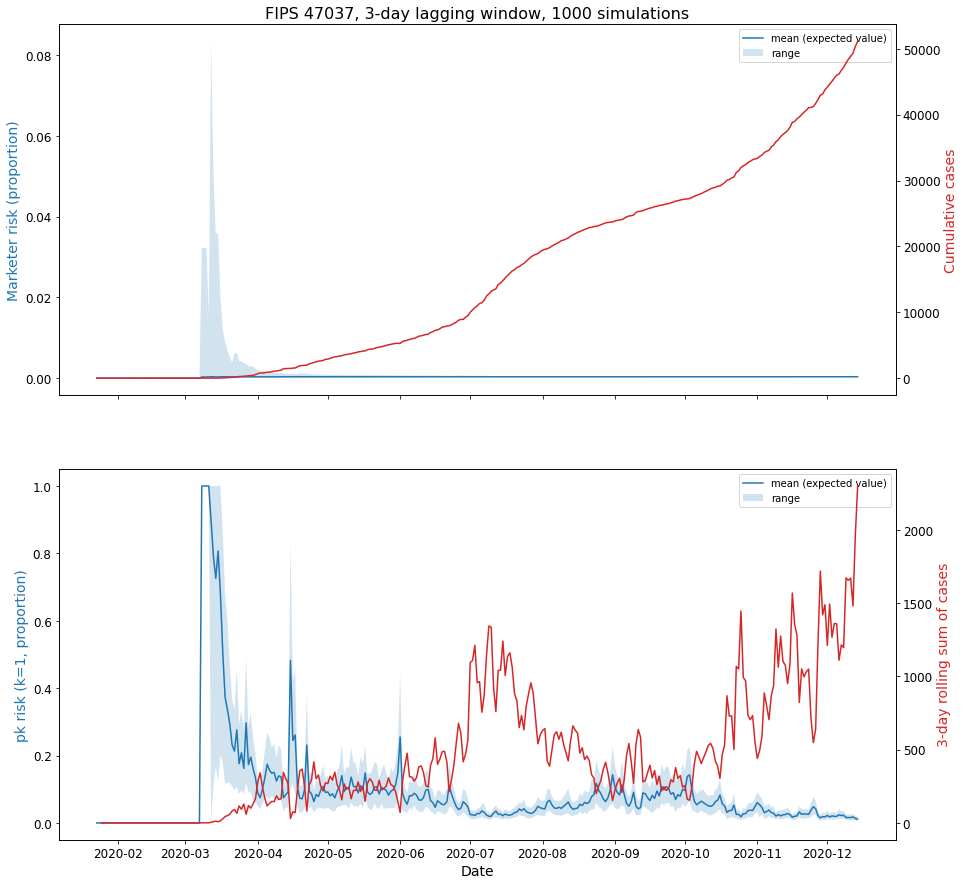

In [22]:
# plot the results
fig, ax = plt.subplots(2, 1, figsize=(15,15), sharex=True)

cases = df.loc[fip,:]
cases.index = pd.to_datetime(cases.index)

# marketer risk
ax[0].plot(pd.to_datetime(marketer_risk['date']),
           marketer_risk['mean'].values,
           label='mean (expected value)')
ax[0].fill_between(pd.to_datetime(marketer_risk['date']),
                   marketer_risk['lower'].values,
                   marketer_risk['upper'].values,
                   alpha=0.2, label='range')


ax2 = ax[0].twinx()
ax2.plot(pd.to_datetime(marketer_risk['date']), cases.cumsum(), color='tab:red')

ax[0].legend(loc='best')

ax[0].set_ylabel('Marketer risk (proportion)',
                 color='tab:blue', fontsize=14)
ax2.set_ylabel('Cumulative cases', color='tab:red', fontsize=14)

ax[0].tick_params(labelsize='large')
ax2.tick_params(labelsize='large')

ax[0].set_title('FIPS ' + str(fip) + ', ' + str(wind_size) + '-day lagging window, 1000 simulations',
                fontsize=16)

# pk risk, k=1
ax[1].plot(pd.to_datetime(prop_uniques['date']),
           prop_uniques['mean'].values,
           label='mean (expected value)')
ax[1].fill_between(pd.to_datetime(prop_uniques['date']),
                   prop_uniques['lower'].values,
                   prop_uniques['upper'].values,
                   alpha=0.2, label='range')

ax4 = ax[1].twinx()
ax4.plot(pd.to_datetime(prop_uniques['date']),
         cases.rolling(3, closed='right').sum().values,
         color='tab:red')

ax[1].legend(loc='best')

ax[1].set_ylabel('pk risk (k=1, proportion)',
                 color='tab:blue', fontsize=14)
ax4.set_ylabel(str(wind_size) + '-day rolling sum of cases', color='tab:red', fontsize=14)

ax[1].tick_params(labelsize='large')
ax4.tick_params(labelsize='large')

ax[1].set_xlabel('Date', fontsize=14)